In [1]:
import multiprocessing as mp
import cv2
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.kernel_approximation import Nystroem
from sklearn import svm
from joblib import Parallel, delayed, cpu_count
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle
import time
from datasets.load import load_images
import os

plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams["figure.figsize"] = (15.0, 12.0)  # set default size of plots

# Configuration
please ony change the parameters provided here.

In [3]:
MODEL_DIR = 'cache/'      # directory to save trained model
DATASET_DIR = 'datasets/' # directory to the dataset provided in pascal VOC format
TRAIN_MODEL = False       # Weather or not to train a new SVM model
                          # change to True to retrain
DETECTIONS_DIR = 'detections' # directory to save detection .txt files

SIZE = 128                # pixel size of the training window

# mapping of label names to integers, required for multi label classification in sklearn
LABELS = {"waldo": 0, "wenda": 1, "wizard": 2, "negative": 3}
K = 5                     # K used for kmeans preprocessing


# config for the feature descriptor (do not change)
ORIENTATIONS_G = 9
PIXELS_PER_CELL_G = (16,16)
CELLS_PER_BLOCK_G = (4,4)
ORIENTATIONS_C = 9
PIXELS_PER_CELL_C = (16,16)
CELLS_PER_BLOCK_C = (4,4)



In [4]:
with open(os.path.join(MODEL_DIR, "neg_samples_train.pkl"), 'rb') as f:
    neg_samples = pickle.load(f)
with open(os.path.join(MODEL_DIR, "waldo_train.pkl"), 'rb') as f:
    pos_waldo = pickle.load(f)
with open(os.path.join(MODEL_DIR, "wenda_train.pkl"), 'rb') as f:
    pos_wenda = pickle.load(f)
with open(os.path.join(MODEL_DIR, "wizard_train.pkl"), 'rb') as f:
    pos_wizard = pickle.load(f)


 ## Feature Descritpor

For feature description we use a combination of the HOG (Historgram Orientated Gradients) Descriptor and a SIFT (Scale Invariant Feautre Transform). 

Both detectors generate a $3600$ dimensional feature vector and are concatenated together, creating a $7200$ dimensional feature vector in total.

Below we visualize the results of the HOG descriptor (only part of the final descriptor):

Sample image shape (128, 128), feature vector shape (3600,)
Sample image shape (128, 128), feature vector shape (3600,)
Sample image shape (128, 128), feature vector shape (3600,)
Sample image shape (128, 128), feature vector shape (3600,)


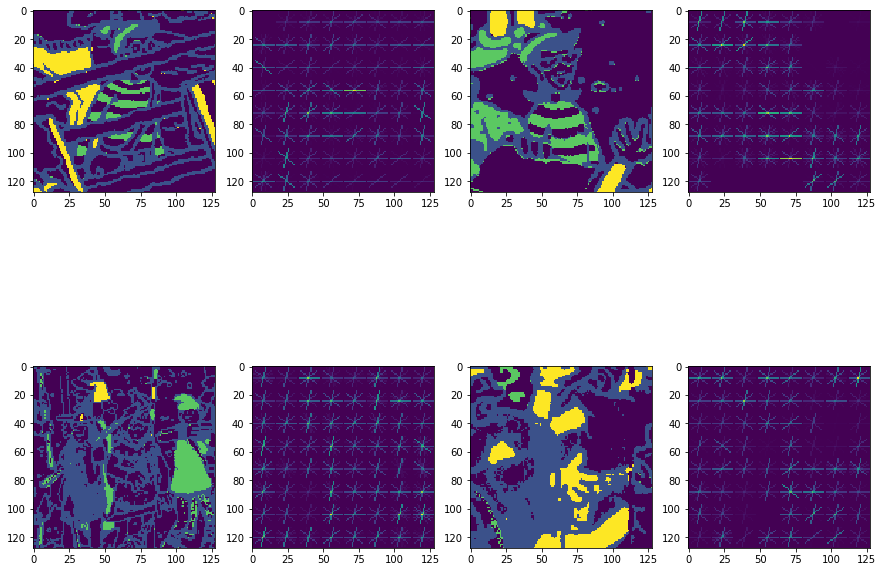

In [5]:
# viualize the descriptor once for each class
for i, s in enumerate([pos_waldo[0], pos_wenda[0], pos_wizard[0], neg_samples[0]]):
    feature, hog_image = hog(
        s,
        orientations=ORIENTATIONS_G,
        pixels_per_cell=PIXELS_PER_CELL_G,
        cells_per_block=CELLS_PER_BLOCK_G,
        visualize=True,
        multichannel=False,
    )
    print(
        "Sample image shape {}, feature vector shape {}".format(s.shape, feature.shape)
    )
    plt.subplot(2, 4, 2 * i + 1)
    plt.imshow(s)
    plt.subplot(2, 4, 2 * i + 2)
    plt.imshow(hog_image)

plt.show()

This calls into `feauture_descritptor.py` for the describe function. Which calls to `sklearn` for the HOG part of the descriptor. The SIFT-like descriptor is called HOV (Histograms over Values) is adapted from the implementaion of HOG in `sklean`.

In [6]:
from feature_descriptor import describe

def feature_descriptor(samples, parallel=False):
    res = None
    if parallel:
        res = Parallel(n_jobs=cpu_count())(
            delayed(describe)(
                s,
                orientations_g=ORIENTATIONS_G,
                pixels_per_cell_g=PIXELS_PER_CELL_G,
                cells_per_block_g=CELLS_PER_BLOCK_G,
                orientations_c=ORIENTATIONS_C,
                pixels_per_cell_c=PIXELS_PER_CELL_C,
                cells_per_block_c=CELLS_PER_BLOCK_C,
            )
            for s in samples
        )
    else:
        res = [
            describe(
                s,
                orientations_g=ORIENTATIONS_G,
                pixels_per_cell_g=PIXELS_PER_CELL_G,
                cells_per_block_g=CELLS_PER_BLOCK_G,
                orientations_c=ORIENTATIONS_C,
                pixels_per_cell_c=PIXELS_PER_CELL_C,
                cells_per_block_c=CELLS_PER_BLOCK_C,
            )
            for s in samples
        ]
    return np.array(res)

Transforming all positive samples into feature space using the afore mentioned descriptor.

In [ ]:
pf_wa = feature_descriptor(pos_waldo, parallel=True)
pf_we = feature_descriptor(pos_wenda, parallel=True)
pf_wi = feature_descriptor(pos_wizard, parallel=True)
nf_s = feature_descriptor(neg_samples, parallel=True)

X = np.concatenate((pf_wa, pf_we, pf_wi, nf_s), axis=0)
Y = np.concatenate(
    (
        np.full(pf_wa.shape[0], LABELS["waldo"]),
        np.full(pf_we.shape[0], LABELS["wenda"]),
        np.full(pf_wi.shape[0], LABELS["wizard"]),
        np.full(nf_s.shape[0], LABELS["negative"]),
    ),
    axis=0,
)

x_train, y_train = X, Y


In [ ]:
print("training data shape: examples: {}, labels: {}".format(x_train.shape, y_train.shape))

pos = pf_wa.shape[0] + pf_we.shape[0] + pf_wi.shape[0]
neg = nf_s.shape[0]
tot = X.shape[0]

print('waldo:    {} {:2.2f}%'.format(pf_wa.shape[0], pf_wa.shape[0]*100/tot))
print('wenda:    {} {:2.2f}%'.format(pf_we.shape[0], pf_we.shape[0]*100/tot))
print('wizard:   {} {:2.2f}%'.format(pf_wi.shape[0], pf_wi.shape[0]*100/tot))
print('negative: {} {:2.2f}%'.format(nf_s.shape[0], nf_s.shape[0]*100/tot))


print('positive examples:\t{}\t{:2.2f}% \nnegative examples\t{}\t{:2.2f}%'.format(pos, pos*100/tot, neg, neg*100/tot))


 ## Train Support Vector Machine Classifier (SVC)
 
 Here we train the actual SVM (Support Vector Machine) classifier form the training samples in feautre space. In Addition to the SVM itself we train a probability model on top of it, to give meaningful probability / confidence scores for each detection. This requires cross validation and cannot be done in parallel and therefore has a **large impact on training time**. 
 
As can be seen from the commented out lines, for the parameter choices of the SVM we used `sklearn`'s inbuilt hyperparamerter search function. Out of all the possible configurations tested, the ones used in line 18 are the ones providing best results.

If one wants to retrain the SVM, we provide one in the cache directory. Just set `TRAIN_MODEL` in the configuration section in the beginning to true and run the cell below. Beware though, this process can take some time, as we cannot use multithreading to train this SVM.


In [ ]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV



print(x_train.shape, y_train.shape)

if TRAIN_MODEL:
    #param_grid = {
    #    'C': [1e-3, 0.01, 0.1, 10, 100, 1000],
    #    'gamma': [1e-4, 1e-3, 0.01, 0.1, 1, 10, 100],
    #    'kernel': ['rbf', 'linear'],
    #}

    # This uses hyperparameter search to find the best model.
    # Therefore it can be quite slow!
    # clf = GridSearchCV(svm.SVC(class_weight='balanced', random_state=0, decision_function_shape='ovo', probability=True),
    #                  param_grid, refit=True, n_jobs=-1, cv=5)

    clf = svm.SVC(C=10, gamma=0.01, kernel='rbf', class_weight='balanced', random_state=0, decision_function_shape='ovo', probability=True)
    clf.fit(x_train, y_train)

    #print('best parameters:')
    #print(clf.best_params_)
    #print(clf.best_estimator_)

    # save model to disk
    with open(os.path.join(MODEL_DIR, "svm_classifier.pkl"), 'wb') as f:
        pickle.dump(clf, f)


In [ ]:
with open(os.path.join(MODEL_DIR, "svm_classifier.pkl"), 'rb') as f:
    clf = pickle.load(f)

 ## Classifier Evaluation
 
We validate our training against the validation set provided in the dataset. The samples first get loaded, then transformed into feature space with the same descriptor, as the testing samples and then classified.
 

In [ ]:
# load testing data
with open(os.path.join(MODEL_DIR, "waldo_test.pkl"), 'rb') as f:
    test_waldo = pickle.load(f)
with open(os.path.join(MODEL_DIR, "wenda_test.pkl"), 'rb') as f:
    test_wenda = pickle.load(f)
with open(os.path.join(MODEL_DIR, "wizard_test.pkl"), 'rb') as f:
    test_wizard = pickle.load(f)
with open(os.path.join(MODEL_DIR, "neg_samples_test.pkl"), 'rb') as f:    
    test_neg_samples = pickle.load(f)[:20]

# transform samples into feature space
test_waldo = feature_descriptor(test_waldo, parallel=True)
test_wenda = feature_descriptor(test_wenda, parallel=True)
test_wizard = feature_descriptor(test_wizard, parallel=True)
test_neg_samples = feature_descriptor(test_neg_samples, parallel=True)

x_test = np.concatenate((test_waldo, test_wenda, test_wizard, test_neg_samples), axis=0)
y_test = np.concatenate(
    (
        np.full(test_waldo.shape[0], LABELS["waldo"]),
        np.full(test_wenda.shape[0], LABELS["wenda"]),
        np.full(test_wizard.shape[0], LABELS["wizard"]),
        np.full(test_neg_samples.shape[0], LABELS["negative"]),
    ),
    axis=0,
)


### Results Report

The classification report gives a good overview of the classifier's performance, by computing precision, recall and $F_1$ (harmonic average of precision and recall) scores.
Also an overall average of all these scores is given, as well as one set per class

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, clf.predict(x_test),
                           target_names=LABELS))

### Confusion Matrix

The confusion matrix gives a good viusual overview of how well the detection performed. Ideally there would only be values on the diagonal

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = clf.predict(x_test)
conf_matrix = confusion_matrix(y_test, y_pred)

ax = plt.subplot()
ax.imshow(conf_matrix, interpolation='nearest')
ax.set(xticks=np.arange(conf_matrix.shape[1]),
       yticks=np.arange(conf_matrix.shape[0]),
       xticklabels=LABELS, yticklabels=LABELS,
       ylabel='True label',
       xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

# Image Classification

To turn our trained classifier into a true detector, we use a sliding window approach. Here many $(SIZE \cdot SIZE)$px windows are generated and if any one of them is predicted to be one of the positive classes (`waldo`, `wenda`, `wizard`) it is added to the list of detections.

In detail, we transform each window to feautre space, by first scaling it to $(SIZE \cdot SIZE) $ px, then performing the same kmeans preprocessing step on it, as in the sample generation and the feeding that result into our descriptor, explained above. To speed this process up, we transform all windows in parallel. Still this step might take some time, depending on the available computational ressouces.

For each transformed window, now in feature space, we run the classifier. If it's result is one of the positive classes, we query the associated probailiy $p$ with that class. Also we compute the $p_{raito} = \frac{p_{max}}{p_{max-1}}$ value, which is the ratio of the two highest probabilites, giving a measue of how confident the classifier is of that class in relation to all other ones.

Once all windows have been classified, we perform non-maximum suppression. For this we generate groups for all sets of overlapping positive classifications. Then choose the representative with the maximum $p$ probability for each window. Additionally we remove all windows where $p_{ratio} < 1.5$. This removes detections where the classifier is generally inconfident, where the value of $1.5$ was determined experimentally.

In the last step the remaining detections after non-maximum suppression are plotted with ground truth bounding boxes if they were given to the predictor. For each prediction the following information is given:
$ (name, p, p_{ratio}) $


In [ ]:
# load the kmeans model from disk
with open(os.path.join(MODEL_DIR, "neg_samples_test.pkl"), 'rb') as f:   
    kmeans = pickle.load(f)
    
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d), dtype=np.uint8)
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i,j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

def process_img(img):
    w,h,d = img.shape
    labels = kmeans.predict(np.reshape(img, (w*h,d)))
    
    white_idx =  np.argmin([np.linalg.norm(np.array([253, 253, 253]) - c) for c in kmeans.cluster_centers_])
    other_col_idx = np.argmin([np.linalg.norm(np.array([182,159,154]) - c) for c in kmeans.cluster_centers_])
    labels[labels == other_col_idx] = white_idx
    
    c = (np.arange(0,K) * 255 / (K-1)).astype(np.uint8)[np.newaxis].T
    cluster_centers = np.hstack([c,c,c])
    return recreate_image(cluster_centers, labels, w,h)[:,:,0]

In [ ]:
## this is adapted from https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def bbx_iou(bbx1, bbx2):
    assert bbx1['x1'] < bbx1['x2']
    assert bbx1['y1'] < bbx1['y2']
    assert bbx2['x1'] < bbx2['x2']
    assert bbx2['y1'] < bbx2['y2']
    
    # determine the coordinates of the intersection rectangle
    x_left = max(bbx1['x1'], bbx2['x1'])
    y_top = max(bbx1['y1'], bbx2['y1'])
    x_right = min(bbx1['x2'], bbx2['x2'])
    y_bottom = min(bbx1['y2'], bbx2['y2'])
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    
    # compute the area of both AABBs
    bbx1_area = (bbx1['x2'] - bbx1['x1']) * (bbx1['y2'] - bbx1['y1'])
    bbx2_area = (bbx2['x2'] - bbx2['x1']) * (bbx2['y2'] - bbx2['y1'])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bbx1_area + bbx2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

def non_max_suppression(detections, threshold=0.0):
    if len(detections) == 0: return detections
    
    groups = [[detections[0]]]
    # group detections if overlap is greather than threshold
    for d in detections:
        for idx, g in enumerate(groups):
            if np.max([bbx_iou(d['w'], bbx['w']) for bbx in g]) > threshold:
                groups[idx].append(d)
                break
        else:
            groups.append([d])
        
    detections = []
    for g in groups:
        detections.append(g[np.argmax(x['p'] for x in g)])
    # delte detection if p_ratio is less than 1.5
    detections = [d for d in detections if d['p_ratio'] > 1.5]
    return detections


In [ ]:
def draw_bbox(ax, text, box, col='r'):
    r = patches.Rectangle((box['x1'], box['y1']), 
                          box['x2'] - box['x1'],
                          box['y2'] - box['y1'],
                          linewidth=3,
                          edgecolor=col,
                          facecolor='none')
    ax.add_patch(r)
    ax.text(box['x1'], box['y1'], text,
            bbox={'facecolor': col, 'linewidth': 0})

def draw_annotation(ax, classes):
    for idx, cl in enumerate(classes):
        col = 'g'
        for box in cl['bounds']:
            draw_bbox(ax, cl['name'], box, col)

def dict_invert(key, d):
    return set(k for k, v in d.items() if v == key).pop()

def variance(img, w=None, size=250):
    if w is not None:
        img = img[w['y1']:w['y2'], w['x1']:w['x2']]

    r = np.random.choice(img[:,:,0].ravel(), size)
    g = np.random.choice(img[:,:,1].ravel(), size)
    b = np.random.choice(img[:,:,2].ravel(), size)
    return np.array([np.var(r), np.var(g), np.var(b)])

def _transform_feature(img, w, var):
    #if np.max(variance(img, w)) < var:
    #    return ({}, None)
    window = cv2.resize(img[w['y1']:w['y2'], w['x1']:w['x2']], dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
    return (w, feature_descriptor([process_img(window)]))

def _predict(w, feat_vect):
    if feat_vect is None: return None
    
    label = clf.predict(feat_vect)[0]
    
    
    if LABELS['negative'] != label:
        proba = clf.predict_proba(feat_vect)[0]
        p_ratio = proba[label] / np.max(proba[proba != proba[label]])
        
        d = {'w':w, 'class':dict_invert(label, LABELS), 'p':proba[label], 'p_ratio': p_ratio}
        print(d)
        return d
    return {}

def detect_img(img, ground_truth=None):
    img_y, img_x = img.shape[:2]
    size = 128
                  
    var = np.mean(variance(img, size=1000)) * 2/3
    print('performing detection on image of size {} with window size {}'.format(img.shape, size))
        
    with mp.Pool(mp.cpu_count()) as p:
        args = []
        for scale in [1, 2, 4, 6]:
            window_size = int(size * scale)
            for y in range(0, img_y - window_size, window_size // 4):
                for x in range(0, img_x - window_size, window_size // 4):
                    args.append((img, 
                                 {'y1':y, 'y2':y + window_size, 
                                  'x1':x, 'x2':x + window_size},
                                 var))

        print("transforming image windows into feature space")

        feature_vectors = p.starmap(_transform_feature, args)

        print('... done')
        print("detecting classes for windows")
        print('detections:')
        
        detections = p.starmap(_predict, feature_vectors)
        
        
        omitted = 0
        detections_ = []
        for d in detections:
            if d: detections_.append(d)
            elif d is None: omitted += 1
        detections = detections_   

    
    print('omitted {:2f}% of windows'.format(omitted / len(feature_vectors)*100))
    print('evaluated {} windows'.format(len(feature_vectors)))
    
    detections = non_max_suppression(detections)
    print('num classes after non_max_supp: {}'.format(len(detections)))
    
    ax = plt.subplot(1, 1, 1)
    plt.imshow(img)
    # draw gound truth
    #draw_annotation(ax, sample['classes'])

    # draw detections
    for d in detections:
        draw_bbox(ax, '{} $({:2.1f},{:2.1f})$'.format(d['class'], d['p'], d['p_ratio']), d['w'])
    if ground_truth is not None:
        draw_annotation(ax, ground_truth)
        
    plt.show()
    return np.array(detections)
    

In [ ]:
def rescale(img, min_size=3000, max_size=4096, ground_truth_boxes=None):
    h,w = img.shape[:2]
    if max(h,w) > max_size:
        if w > h:
            dsize = (max_size, int(h * max_size / w))
            s = max_size/w
        else:
            dsize = (int(w * max_size / h), max_size)
            s = max_size/h
    elif min(h,w) < min_size:
        if w > h:
            dsize = (int(w * min_size / h), min_size)
            s = min_size/h
        else:
            dsize = (min_size, int(h * min_size / w))
            s = min_size/w

    img = cv2.resize(img, dsize=dsize, interpolation=cv2.INTER_LINEAR)
    
    if ground_truth_boxes:
        gt = []
        for cl in ground_truth_boxes:
            gt.append({
                'name': cl['name'],
                'bounds': [{'x1': int(b['x1']*s), 'y1': int(b['y1']*s),
                            'x2': int(b['x2']*s), 'y2': int(b['y2']*s)} for b in cl['bounds']]
            })
        return img, gt, s
    else:
        return img, s

## Classification of validation images

As an example we run the classifier on the validation training set. However all of the images in the dataset have varying sizes. Assuming all of them are scans from the same book (i.e. same paper size) we can confidently rescale all images to the same size (while preserving asprect ratios), to keep a consistent relation of pixel sizes given to the detector and real world size of the printed characters. 

For a detailed description of how these values we determined form the dataset, see `dataset_analytics.py` or the corresponding section in the report.

As we use a scaled version of the images in the detector, we also scale ground truth bounding boxes and detections accordingly to make the transformation transparent to the end user.

Lastly we save the detection results (`waldo.txt`, `wenda.txt` and `wizard.txt`) in the required format to `DETECTIONS_DIR`. 

In [ ]:
samples = load_images('val', DATASET_DIR)

In [ ]:
# final detections output
output = {
    'waldo': [],
    'wenda': [],
    'wizard': []
}

for sample in samples:      
    start = time.perf_counter()
    
    img, gt, s = rescale(sample['img'], ground_truth_boxes=sample['classes'])
    detections = detect_img(img, ground_truth=gt)
    
    print('elapsed time {} s'.format(time.perf_counter() - start))
    print('\n\n\n')
    
    # append detections to list
    for d in detections:
        output[d['class']].append('{} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}'.format(sample['filename'].strip('.jpg'), 
                                                             d['p'], 
                                                             d['w']['x1']/s, 
                                                             d['w']['y1']/s, 
                                                             d['w']['x2']/s, 
                                                             d['w']['y2']/s))

# write detections to file
for name, d in output.items():
    with open(os.path.join(DETECTIONS_DIR, '/{}.txt'.format(name)), 'w') as f:
        f.write('\n'.join(d))

## mAP Score
Here we display the mAP score for our detetions, as well as the one reqired in baseline results.

In [ ]:
from voc_eval import voc_eval
overlap = 0.1
print('baseline results:')
for name, _ in output.items():
    rec, prec, ap = voc_eval('baseline/{}.txt'.format(name),
                             os.path.join(DATASET_DIR, 'Annotations/{}.xml'.format(name)),
                             os.path.join(DATASET_DIR,'ImageSets/val.txt'), 
                             name, 
                             MODEL_DIR, 
                             ovthresh=overlap)
    print('{:>10}  mAP: {:.2f}'.format(name, ap))
    
print('detection results:')
for name, _ in output.items():
    rec, prec, ap = voc_eval(os.path.join(DETECTIONS_DIR, '{}.txt'.format(name)), 
                             os.path.join(DATASET_DIR, 'Annotations/{}.xml'.format(name)),
                             os.path.join(DATASET_DIR,'ImageSets/val.txt'), 
                             name, 
                             MODEL_DIR, 
                             ovthresh=overlap)
    print('{:>10}  mAP: {:.2f}'.format(name, ap))


## Classification of new images

To classify a new image, change the variables below to point to the image path and give a valid results path. 

In [ ]:
IMG_PATH = 'datasets/JPEGImages/000.jpg'
DETECTIONS_DIR = '.'

img = cv2.cvtColor(cv2.imread(IMG_PATH), cv2.COLOR_BGR2RGB)
# final detections output
output = {
    'waldo': [],
    'wenda': [],
    'wizard': []
}

start = time.perf_counter()

img_rescaled, s = rescale(img)
detections = detect_img(img_rescaled)

print('elapsed time {} s'.format(time.perf_counter() - start))
print('\n\n\n')

# append detections to list
for d in detections:
    _, ext = os.path.splitext(IMG_PATH)
    img_name = os.path.basename(IMG_PATH).strip(ext)

    output[d['class']].append('{} {:.3f} {:.1f} {:.1f} {:.1f} {:.1f}'.format(img_name, 
                                                         d['p'], 
                                                         d['w']['x1']/s, 
                                                         d['w']['y1']/s, 
                                                         d['w']['x2']/s, 
                                                         d['w']['y2']/s))

# write detections to file
for name, d in output.items():
    with open(os.path.join(DETECTIONS_DIR, '/{}.txt'.format(name)), 'w') as f:
        f.write('\n'.join(d))